# Calgary Stampeders - Event Propensity MVP
* StellarAlgo Data Science
* Nakisa Rad & Ryan Kazmerik
* May 26, 2022

## Hypothesis
We think that using our Stellar Event Propensity model, we can produce a list of fans that have higher probability to purchase a individual ticket to a game based on their previous purchasing and engagement behaviour.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import boto3
import getpass
import pyodbc
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

from pycaret.classification import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 35 # stamps
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCFL].[ds].[PropensityEventTraining] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(16924, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16924 entries, 0 to 16923
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   daysOut              16924 non-null  object        
 1   minDaysOut           16924 non-null  int64         
 2   maxDaysOut           10424 non-null  float64       
 3   dimCustomerMasterId  16924 non-null  int64         
 4   recent_openRate      16924 non-null  float64       
 5   recent_clickRate     16924 non-null  float64       
 6   eventDate            16924 non-null  datetime64[ns]
 7   eventName            16924 non-null  object        
 8   inMarket             14129 non-null  object        
 9   distanceToVenue      14129 non-null  float64       
 10  tenure               16924 non-null  int64         
 11  did_purchase         16924 non-null  int64         
 12  events_purchased     16924 non-null  int64         
 13  frequency_opponent   16924 non-

In [5]:
# choose the features for the stellar base retention model
features = [
                "daysOut",
                #"minDaysOut",
                #"maxDaysOut",
                "dimCustomerMasterId",
                "recent_openRate",
                "recent_clickRate",
                "eventDate",
                #"eventName",
                "inMarket",
                "distanceToVenue",
                "tenure",
                "did_purchase",
                "events_purchased",
                "frequency_opponent",
                "frequency_eventDay",
                "frequency_eventTime"
                #"count_merchOwned"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14385, 13)
Unseen Data For Predictions: (2539, 13)



In [6]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId"],
    silent=True,
    verbose=False,
    numeric_features=[
                #"minDaysOut",
               # "maxDaysOut",
                "recent_openRate",
                "recent_clickRate",
                "distanceToVenue",
                "tenure",
                "events_purchased",
                "frequency_opponent",
                "frequency_eventDay",
                "frequency_eventTime"
                #"count_merchOwned"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["dt", "gbc", "lightgbm", "lr", "rf", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7250,0.8109,0.7138,0.7331,0.7231,0.4501,0.4505,0.0520
gbc,Gradient Boosting Classifier,0.7178,0.8036,0.7128,0.7229,0.7176,0.4357,0.4361,0.3790
xgboost,Extreme Gradient Boosting,0.7147,0.7991,0.7055,0.7217,0.7133,0.4295,0.4298,0.7360
rf,Random Forest Classifier,0.7012,0.7777,0.6951,0.7071,0.7007,0.4025,0.4030,0.2540
lr,Logistic Regression,0.6918,0.7619,0.6685,0.7042,0.6857,0.3838,0.3845,0.2100
dt,Decision Tree Classifier,0.6470,0.6477,0.6451,0.6509,0.6477,0.2940,0.2942,0.9450


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7122,0.7981,0.6959,0.7218,0.7086,0.4245,0.4247
1,0.7465,0.8278,0.7561,0.7440,0.7500,0.4930,0.4931
2,0.7302,0.8179,0.7122,0.7411,0.7264,0.4604,0.4608
3,0.7212,0.8042,0.7171,0.7253,0.7212,0.4424,0.4424
4,0.7171,0.7918,0.7273,0.7157,0.7214,0.4341,0.4341
5,0.7179,0.8090,0.6997,0.7293,0.7142,0.4360,0.4363
6,0.7269,0.8169,0.6802,0.7536,0.7150,0.4542,0.4564
7,0.7316,0.8174,0.7122,0.7436,0.7276,0.4633,0.4637
8,0.7283,0.8133,0.7252,0.7323,0.7288,0.4566,0.4567
9,0.7185,0.8121,0.7122,0.7240,0.7180,0.4370,0.4371


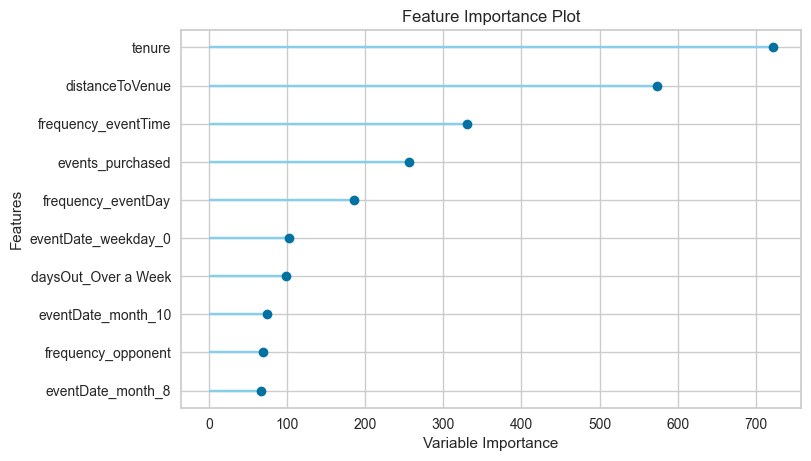

In [9]:
plot_model(final_model, plot='feature')

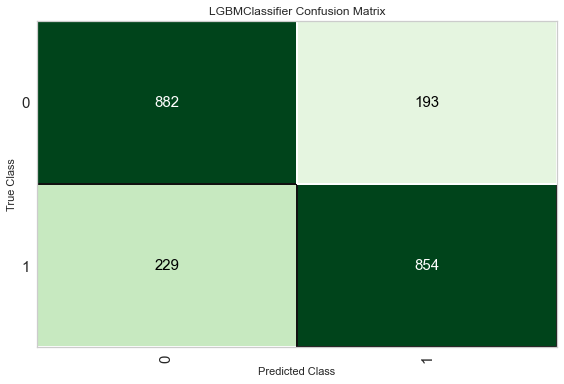

In [10]:
plot_model(final_model, plot='confusion_matrix')

In [11]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

TSVB-CPRM
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


In [12]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'qa-app'
DBNAME = 'stlrcfl'

creds = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

# create a connection & cursor and call the stored procedure
conn = psycopg2.connect(
    host = 'qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds['DbUser'],
    password = creds['DbPassword'],
    database = DBNAME
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: qa-app stlrcfl


In [13]:
game_dates= ['2022-06-09','2022-06-25','2022-07-30','2022-08-13','2022-09-05','2022-09-17','2022-10-01','2022-10-14','2022-10-29']

predictions =[]
for game_date in game_dates:
    
    cur = conn.cursor()
    cur.execute(f"CALL dw.geteventpropensityscoringmodeldata(35, '{game_date}', 'rkcursor')")

    # create a named cursor based on the cursor name passed in above
    named_cursor = conn.cursor('rkcursor')
    data = named_cursor.fetchall()

    # load the data and columns into a data frame
    cols = [row[0] for row in named_cursor.description]
    df_scoring = pd.DataFrame(data=data, columns=cols)
    df_scoring = df_scoring.fillna(0)
    
    # get predictions from the model for each game
    new_predictions = predict_model(final_model, data=df_scoring, raw_score=True)
    predictions.append(new_predictions)
    
    conn.commit()

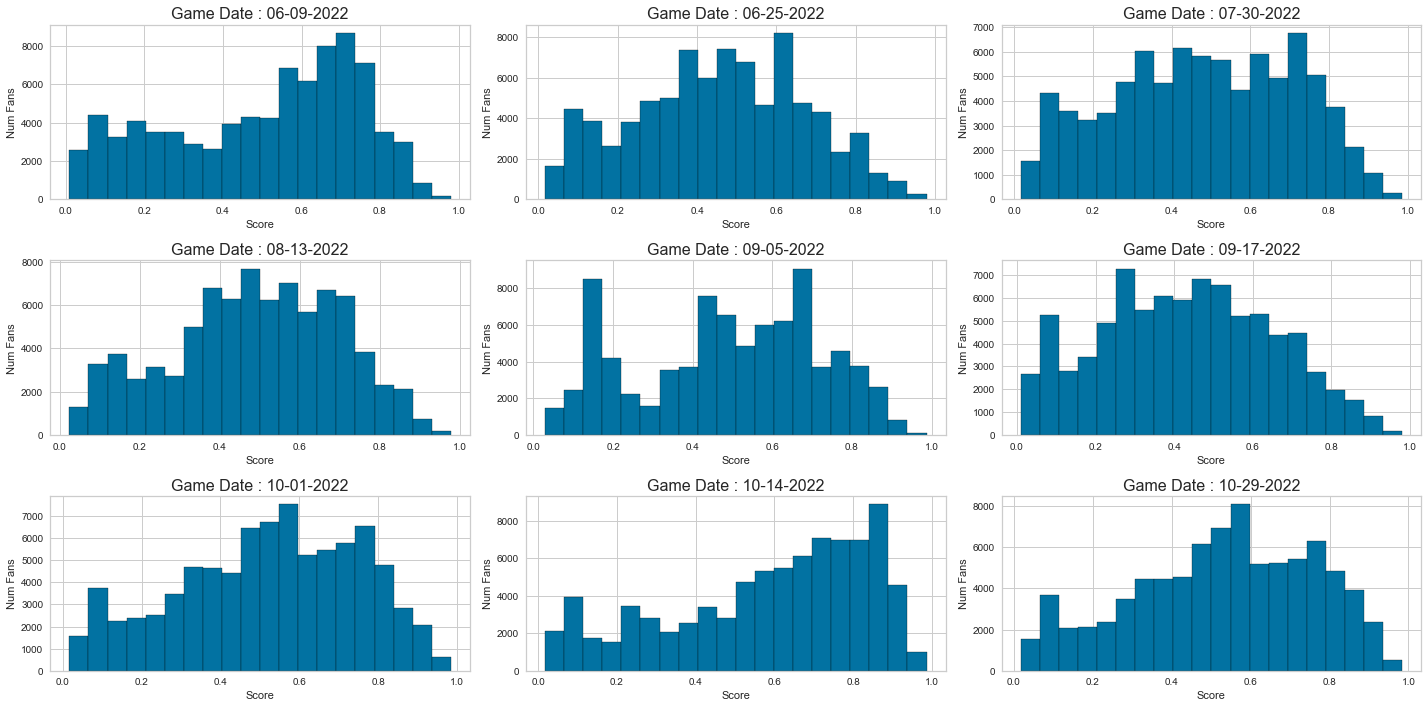

In [54]:

for idx, df_game in enumerate(predictions):    
    
    
    plt.subplot(3, 3, idx+1)

    event_date = df_game['eventDate'].unique()[0].strftime("%m-%d-%Y")

    plt.title("Game Date : " + event_date, fontsize=16)
    plt.xlabel('Score')
    plt.ylabel('Num Fans')
    plt.hist(df_game['Score_1'], bins=20, edgecolor="black")


plt.tight_layout()
plt.show()

In [57]:
for df_game in predictions:

    event_date = df_game['eventDate'].unique()[0].strftime("%m-%d-%Y")
    df_game.to_csv(f"results/stamps_ep_scores_{event_date}.csv", index=False)

## Observations

1. How accurate was this model? 
2. How many fans scored over 0.80 for the 2022 season?
3. What were the most important features in making a correct prediction?

## Conclusion

Make a recommendation on if and how we should use these scores.